In [1]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.ion()
%matplotlib inline

Using Theano backend.


In [2]:
dfiles = glob.glob('/Users/davidleifer/Desktop/DanDoesData/self-driving/data/*.h5')
dfile = dfiles[0]
h5f = h5py.File(dfile,'r')
A = dict(h5f.items())

In [3]:
dfiles

['/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0001.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0002.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0003.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0004.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0005.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0006.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0007.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0008.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0009.h5',
 '/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0010.h5']

In [4]:
dfile

'/Users/davidleifer/Desktop/DanDoesData/self-driving/data/train_0001.h5'

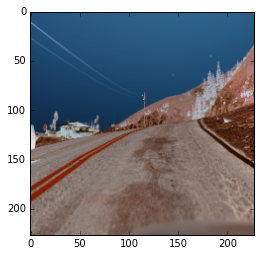

In [5]:
plt.imshow(A['images'].value[0].swapaxes(0,2).swapaxes(0,1))
AA = A['images'].value

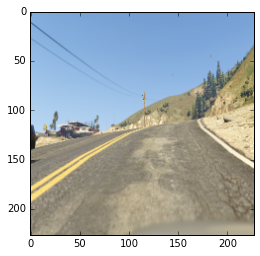

In [6]:
A['targets'].value[:2]
A['vehicle_states'].value[:2]

at = A['targets'].value[:-1]
av = A['vehicle_states'].value[1:]

# slim inputs
B = np.array(A['images'].value,dtype=np.uint8)
plt.imshow(B[0][::-1,:,:].transpose((1,2,0)))

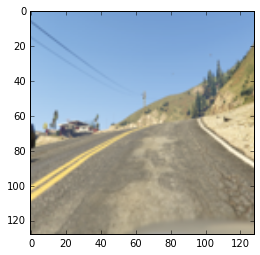

In [7]:
B = B[:,::-1,:,:]
bb = scipy.misc.imresize(B[0],(128,128),'cubic','RGB')
plt.imshow(bb)

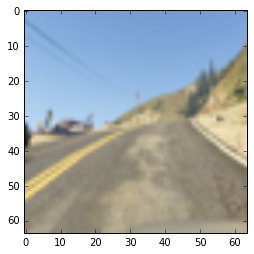

In [8]:
bb = scipy.misc.imresize(B[0],(64,64),'cubic','RGB')
plt.imshow(bb)

In [9]:
speedmax = None
speedmin = None
accelmax = None
accelmin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        #rawr data
        A = dict(h5f.items())
        smx = np.max(A['vehicle_states'].value[:,2])
        smn = np.min(A['vehicle_states'].value[:,2])
        amx = np.max(A['vehicle_states'].value[:,3])
        amn = np.min(A['vehicle_states'].value[:,3])
        if speedmax is None or smx > speedmax:
            speedmax = smx
        if speedmin is None or smn < speedmin:
            speedmin = smn
        if accelmax is None or amx > accelmax:
            accelmax = amx
        if accelmin is None or amn < accelmin:
            accelmin = amn
        #plt.plot(A['targets'].value[:,2],A['targets'].value[:,4],'.')

In [10]:
throttlemax = None
throttlemin = None
steermax = None
steermin = None
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        smx = np.max(A['targets'].value[:,4])
        smn = np.min(A['targets'].value[:,4])
        tmx = np.max(A['targets'].value[:,5])
        tmn = np.min(A['targets'].value[:,5])
        if steermax is None or smx > steermax:
            steermax = smx
        if steermin is None or smn < steermin:
            steermin = smn
        if throttlemax is None or tmx > throttlemax:
            throttlemax = tmx
        if throttlemin is None or tmn < throttlemin:
            throttlemin = tmn

In [11]:
ndata = 0
imgsize = 64
# frame size
nrows = 64
ncols = 64

In [12]:
# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols))

In [13]:
conv1 = Convolution2D(8,5,5,border_mode='same')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

In [14]:
conv2 = Convolution2D(8,5,5,border_mode='same')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)

flat = Flatten()(pool_l2)

M = merge([flat,real_in], mode='concat', concat_axis=1)

D1 = Dense(64)(M)
ED1 = ELU()(D1)
D2 = Dense(32)(ED1)
ED2 = ELU()(D2)
D3 = Dense(32)(ED2)
ED3 = ELU()(D3)

A1 = Dense(32)(ED3)
EA1 = ELU()(A1)
S1 = Dense(32)(ED3)
ES1 = ELU()(S1)

In [15]:
Accel = Dense(1, activation='sigmoid')(EA1)
Steer = Dense(1, activation='sigmoid')(ES1)

model = Model(input=[real_in, frame_in], output=[Accel,Steer])

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.float16)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.float16)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel scale
        speedx = A['vehicle_states'].value[:,2:4]
        speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = A['targets'].value[:,4:]

        h = model.fit([speedx, imgs], [targets[:,1], targets[:,0]],
                        batch_size = 32, nb_epoch=10, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 5s - loss: 0.1727 - dense_6_loss: 0.1623 - dense_7_loss: 0.0105 - dense_6_acc: 0.0830 - dense_7_acc: 0.3160     
Epoch 2/10
1000/1000 [==============================] - 5s - loss: 0.1617 - dense_6_loss: 0.1546 - dense_7_loss: 0.0071 - dense_6_acc: 0.0830 - dense_7_acc: 0.3160     
Epoch 3/10
1000/1000 [==============================] - 4s - loss: 0.1617 - dense_6_loss: 0.1546 - dense_7_loss: 0.0071 - dense_6_acc: 0.0830 - dense_7_acc: 0.3160     
Epoch 4/10
1000/1000 [==============================] - 4s - loss: 0.1617 - dense_6_loss: 0.1546 - dense_7_loss: 0.0071 - dense_6_acc: 0.0830 - dense_7_acc: 0.3160     
Epoch 5/10
1000/1000 [==============================] - 4s - loss: 0.1617 - dense_6_loss: 0.1546 - dense_7_loss: 0.0071 - dense_6_acc: 0.0830 - dense_7_acc: 0.3160     
Epoch 6/10
1000/1000 [==============================] - 4s - loss: 0.1617 - dense_6_loss: 0.1546 - dense_7_loss: 0.0071 - dense_6_acc: 0.0830 - dense_7_acc

In [33]:
W = model.get_weights()

In [34]:
W

[array([[[[ 0.10075132,  0.11766813,  0.02291954,  0.02861121, -0.02457539],
          [-0.00244837, -0.013722  , -0.13748181, -0.00548856, -0.06835603],
          [-0.08276907, -0.04667326,  0.10094545, -0.09607185, -0.00472964],
          [ 0.10505836, -0.03195668,  0.04483284,  0.13930774,  0.14172289],
          [-0.07455976,  0.02079652,  0.08904861, -0.06140227, -0.04925489]],
 
         [[-0.14066662, -0.11808962, -0.00667439,  0.00924796, -0.0491818 ],
          [-0.07868005, -0.00276884,  0.07639749, -0.14585713,  0.00960196],
          [-0.12094516, -0.03767299,  0.06329541,  0.04852068, -0.14120618],
          [-0.09615858,  0.1031385 ,  0.01947992, -0.09764407, -0.11971837],
          [-0.09369244,  0.12687185, -0.11959634,  0.11117655, -0.1285826 ]],
 
         [[ 0.04740144,  0.10966456,  0.01922285,  0.13791202, -0.06859485],
          [ 0.03616696, -0.1459693 ,  0.14045826, -0.06297117, -0.03373664],
          [-0.01342054, -0.12164931, -0.03115868,  0.08559161,  0.0014

In [35]:
h

[array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 

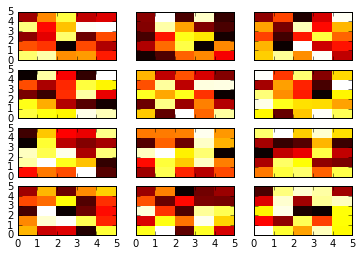

In [36]:
f, con = plt.subplots(4,3, sharex='col', sharey='row')
for row in range(4):
    for col in range(3):
        con[row,col].pcolormesh(W[0][row,col],cmap=plt.cm.hot)

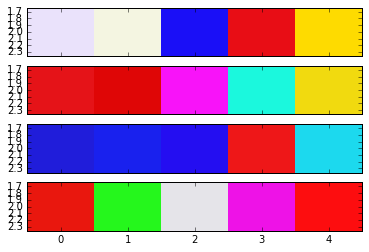

In [37]:
# combine color channels into on filter image
f, con = plt.subplots(4,1, sharex='col', sharey='row')
for row in range(4):
    con[row].imshow(W[0][row].transpose((1,2,0)),
                    interpolation="none")

In [ ]:
all_pred = []
for dfile in dfiles:
    with h5py.File(dfile,'r') as h5f:
        # raw data
        A = dict(h5f.items()) 
        # extract images in 1-byte format
        B = np.array(A['images'].value,dtype=np.uint8)/255.
        # change BGR to RGB
        B = B[:,::-1,:,:]
        # Scale down image size
        imgs = np.zeros((len(B),3,64,64),dtype=np.uint8)
        for i,b in enumerate(B):
            imgs[i] = scipy.misc.imresize(b,(64,64),'cubic','RGB').transpose((2,0,1))
        # speed and accel
        speedx = A['vehicle_states'].value[:,2:4]
        speedx[:,0] = (speedx[:,0] - speedmin) / (speedmax-speedmin)
        speedx[:,1] = (speedx[:,1] - accelmin) / (accelmax-accelmin)
        # throttle and steering scale
        targets = (A['targets'].value[:,4:] + 1) / 2.
        # Train while we have this file open
        h = model.predict([speedx, imgs],
                batch_size = 32, verbose=1)
        all_pred.append(h)

1000/1000 [==============================] - 1s     


In [ ]:
plt.plot(np.array([all_pred[-1].reshape(1000),targets_cat]).T,'.')

In [27]:
def get_point(s,start=0,end=63,height= 48):
    X = int(s*(end-start))
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)

In [28]:
from PIL import Image, ImageDraw
import matplotlib.animation as animation

In [29]:
figure = plt.figure()

In [30]:
figure


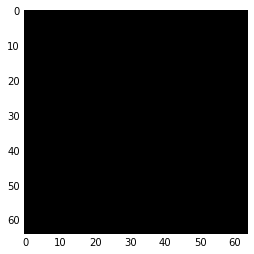

In [31]:
imageplot = plt.imshow(np.zeros((64, 64, 3), dtype=np.uint8))

In [32]:
def next_frame(i):
    im = Image.fromarray(np.array(imgs[i].transpose(1,2,0),dtype=np.uint8))
    draw = ImageDraw.Draw(im)
    draw.line((21,48, 21,all_pred[-1][i]*48),
             fill=(0,255,0,128))
    draw.line((42,48, 42,targets[i]*48),
             fill=(0,255,0,128))
    imageplot.set_array(im)
    return imageplot,
animate = animation.FuncAnimation(figure, next_frame, frames=range(len(imgs)), interval=100, blit=False)
plt.show()

In [86]:
for datafile in dfiles[-1:]:
    with h5py.File(datafile) as data:
        figure = plt.figure()
        imageplot = plt.imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        def next_frame(i):
            im = Image.fromarray(np.array(imgs[i].transpose(1,2,0),dtype=np.uint8))
            draw = ImageDraw.Draw(im)
            draw.line((21,48, 21,all_pred[-1][i]*48),
                     fill=(0,255,0,128))
            draw.line((42,48, 42,targets[i]*48),
                     fill=(0,255,0,128))
            imageplot.set_array(im)
            return imageplot,
        animate = animation.FuncAnimation(figure, next_frame, frames=range(len(imgs)), interval=100, blit=False)
        plt.show()

SystemError: <built-in method draw_lines of ImagingDraw object at 0x111254c90> returned a result with an error set